In [1]:
!pip install torchsummary

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
#from google.colab import drive
from torch import nn
from torchsummary import summary
from time import time
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.nn.functional import softmax
import torchvision.transforms as transforms
from torchvision.models import resnet50, vgg16, alexnet
import time

In [3]:
#data_path = './drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/BrainTumorClassification'
#data_path = './drive/MyDrive/test_data/BrainTumorClassification'
data_path = '/kaggle/input/braintumorclassificationmri/SmallData'
tumor_path = data_path + '/Tumor'
normal_path = data_path + '/Normal'

In [4]:
os.listdir(data_path)

['Tumor', 'Normal']

In [5]:
os.listdir(tumor_path)
os.listdir(normal_path)

['6.jpg',
 'image(186).jpg',
 'image(173).jpg',
 'image(174).jpg',
 'image(291).jpg',
 'image(284).jpg',
 '8.jpg',
 'image(258).jpg',
 'image(215).jpg',
 'image(184).jpg',
 'image(168).jpg',
 'image(207).jpg',
 'image(293).jpg',
 'image(226).jpg',
 'image(325).jpg',
 'image(234).jpg',
 'image(288).jpg',
 'image(73)(1).jpg',
 'image(148).jpg',
 'image(176).jpg',
 'image(165).jpg',
 'image(209).jpg',
 'image(114).jpg',
 'image(259).jpg',
 'image(232).jpg',
 'image(153).jpg',
 'image(190).jpg',
 'image.jpg',
 'image(229).jpg',
 'image(90).jpg',
 'image(185).jpg',
 'image(296).jpg',
 'image(257).jpg',
 'image(231).jpg',
 'image(66).jpg',
 'image(94)(1).jpg',
 'image(273).jpg',
 'image(323).jpg',
 'image(274).jpg',
 'image(211).jpg',
 'image(80).jpg',
 'image(69)(1).jpg',
 'image(263).jpg',
 'image(117).jpg',
 'image(80)(1).jpg',
 'image(100)(1).jpg',
 'image(110).jpg',
 'image(92)(1).jpg',
 'image(113).jpg',
 'image(100).jpg',
 'image(169).jpg',
 'image(97).jpg',
 'image(266).jpg',
 'image

In [6]:
from genericpath import isfile
class BrainDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        #store filenames
        labls = os.listdir(data_dir)
        print (labls) #data_dir altindaki dizin isimleri
        self.labelnames = [] # data_dir içerisindeki etiket listesi, distinct olarak tutuluyor.


        self.filenames = [] #bulunan her bir görüntünün adresi tutuluyor örn: './drive/MyDrive/Gazi Üniversitesi/Uygulamalı Yapay Zeka/2020 dataset_pre processed/Gazi_BRAIN_2020_Dataset/Tumor/img226.jpg'

        for f in labls:

          if f == "models":
            continue
          basedir = os.path.join(data_dir, f) #basedir = data_dir ve alt dizinin birlesmis hali
          if os.path.isfile(basedir):
            pass #readme.txt okunmadan atlanıyor.
          else:
            print(f)
            self.labelnames.append(f)
            print ("basedir=", basedir)
            images = os.listdir(basedir) #basedir altindaki resimlerin listesi
            #print (images)
            fnames = [os.path.join(basedir, im) for im in images] #resimlerin tam dizinli dosya ismi
            self.filenames.extend(fnames) ###################################3 BURADA NE YAPILIYOR?
            #print('dosya isimleri: ', self.filenames)
            #print ('dosya sayısı: ', len(self.filenames))

        #print('etiketler: ', self.labelnames)
        #etiketler dosya isminden aliniyor
        self.labels = [filename.split('/')[-2] for filename in self.filenames] #bulunan her bir görüntünün sırasıyla etiketlerini tutuyor.   ########## NEDEN -2?
        #print ("labels:", self.labels)
        self.transform = transform

    def __len__(self):
        #goruntu listesinin boyutunu dondurur
        return len(self.filenames)

    def numberOfSamples(self):
      a= self.__len__()
      print(type(a))
      return a

    def __getitem__(self, idx):
        #goruntu aciliyor, donusum uygulaniyor ve etiketiyle birlikte donduruluyor
        image = Image.open(self.filenames[idx])  # PIL image

        image = self.transform(image)
        #print(image.size, image.mode)
        label = self.name_to_idx(self.labels[idx])

        #print ('image', type(image))
        #print ('label', type(label))
        return image, label
    def name_to_idx(self, lblname):
        return self.labelnames.index(lblname)
    def idx_to_name(self, lblidx):
        return self.labelnames[lblidx]

In [7]:
t2img = torchvision.transforms.ToPILImage()
img2t = torchvision.transforms.ToTensor()

In [8]:
brain_dataset = BrainDataset(data_path, transform=torchvision.transforms.Compose([
          # torchvision.transforms.RandomHorizontalFlip(p=0.5),
          # torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
          # torchvision.transforms.RandomAffine(degrees=30, shear=10),
          # Resize image and normalize pixels using the provided mean and standard deviation
          # torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
          torchvision.transforms.Resize((256, 256)),
          img2t,
        ]))
print('verisetindeki veri sayısı: ', brain_dataset.numberOfSamples())

#train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(brain_dataset, [0.6, 0.2, 0.2])
train_dataset, test_dataset = torch.utils.data.random_split(brain_dataset, [0.7, 0.3])
print('train setindeki veri sayısı: ', len(train_dataset))
print('test setindeki veri sayısı: ', len(test_dataset))
#print('val setindeki veri sayısı: ', len(val_dataset))

['Tumor', 'Normal']
Tumor
basedir= /kaggle/input/braintumorclassificationmri/SmallData/Tumor
Normal
basedir= /kaggle/input/braintumorclassificationmri/SmallData/Normal
<class 'int'>
verisetindeki veri sayısı:  600
train setindeki veri sayısı:  420
test setindeki veri sayısı:  180


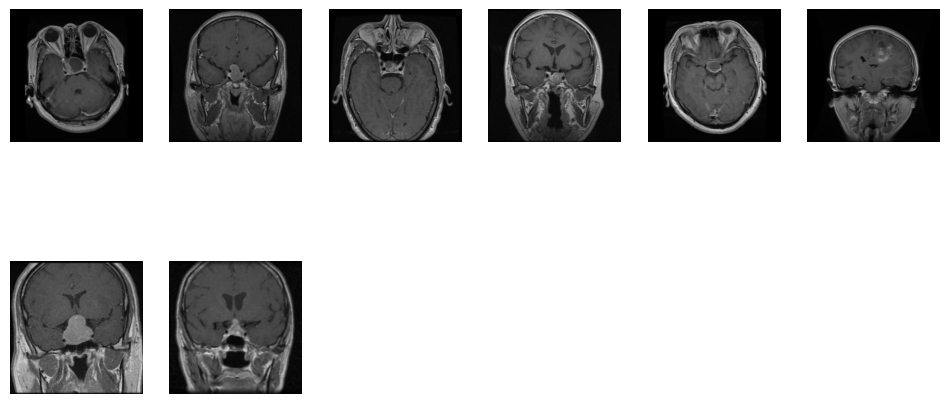

In [9]:
def display_image_grid(images, images_per_row=8):
    if isinstance(images, torch.Tensor):
        images = images.split(1, dim=0)
        images = map(lambda x: x.squeeze(0), images)
        images = list(map(t2img, images))
    elif isinstance(images, list):
        # Expect a list of PIL Images
        if isinstance(images[0], torch.Tensor):
            images = list(map(t2img, images))
        # end if
    elif isinstance(images, Image):
        images = [images]
    else:
        raise RuntimeError(f"Hata: {type(images)}")
    # end if

    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig = plt.figure(figsize=(images_per_row * 2, num_rows * 3))

    for i in range(1, num_images + 1):
        plt.subplot(num_rows, images_per_row, i)
        plt.axis("off")
        plt.imshow(images[i-1])
    # end for

    plt.show()

display_image_grid([
    train_dataset[0][0],
    train_dataset[21][0],
    train_dataset[16][0],
    train_dataset[130][0],
    train_dataset[260][0],
    train_dataset[73][0],
    train_dataset[148][0],
    train_dataset[256][0],
], 6)


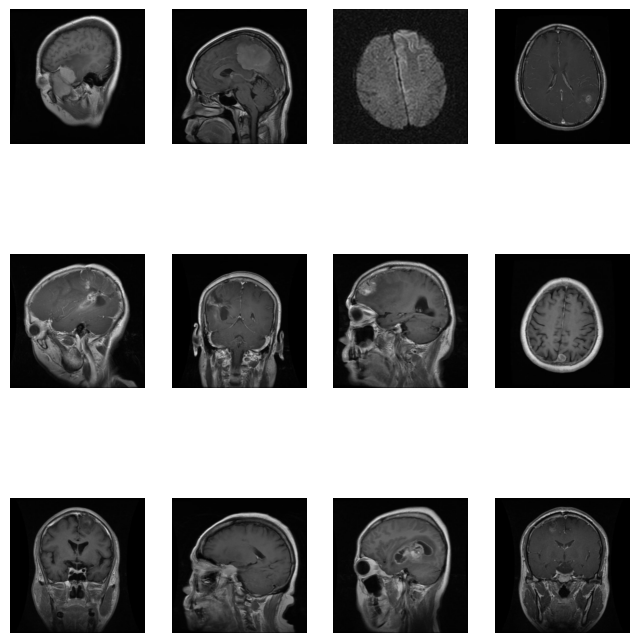

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [10]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=12,
  shuffle=True,
)

inputs, targets = next(iter(train_loader))
display_image_grid(inputs, images_per_row=4)
print (targets)

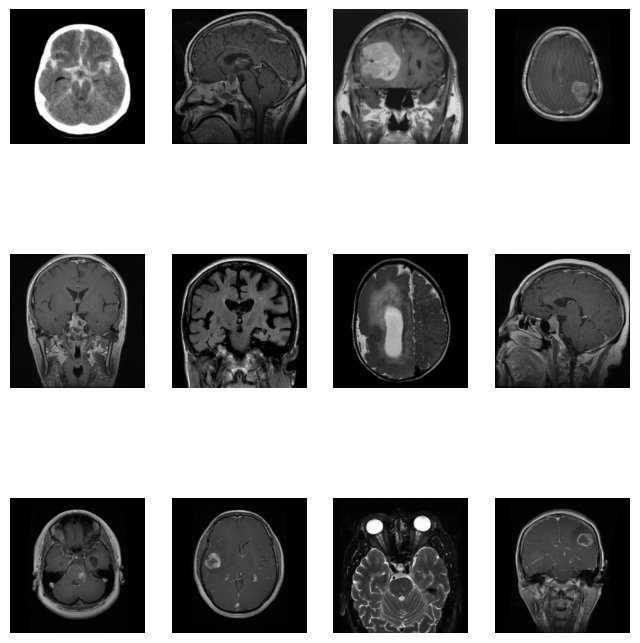

tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])


In [11]:
test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=12,
  shuffle=False,
)

inputs, targets = next(iter(test_loader))
display_image_grid(inputs, images_per_row=4)
print (targets)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cpu


In [14]:
class Solution:
    def __init__(self):
        self.startTime = None
        self.endTime = None
        self.executionTime = None
        self.convergence = None
        self.optimizer = None
        self.objfname = None
        self.best = float('inf')
        self.bestIndividual = None

In [15]:
def HHO(objf, lb, ub, dim, SearchAgents_no, Max_iter):
    if not isinstance(lb, list):
        lb = [lb for _ in range(dim)]
        ub = [ub for _ in range(dim)]
    lb = np.asarray(lb)
    ub = np.asarray(ub)

    # Initialize the locations of Harris' hawks
    X = np.asarray([x * (ub - lb) + lb for x in np.random.uniform(0, 1, (SearchAgents_no, dim))])

    # Initialize convergence
    convergence_curve = np.zeros(Max_iter)
    best_scores = []  # Her iterasyondaki en iyi skorları tutacak liste
    iterations = []  # Her iterasyonu tutacak liste

    s = Solution()

    print("HHO is now tackling  \"" + objf.__name__ + "\"")

    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    t = 0  # Loop counter

    # Main loop
    while t < Max_iter:
        for i in range(0, SearchAgents_no):
            fitness = objf(X[i, :])

            if fitness < s.best:
                s.best = fitness
                s.bestIndividual = X[i, :]

        convergence_curve[t] = s.best
        iterations.append(t)  # Her iterasyonu listeye ekle

        print(['At iteration ' + str(t) + ' the best fitness is ' + str(s.best)])

        #if (t % 1 == 0):
        #    print(['At iteration ' + str(t) + ' the best fitness is ' + str(s.best)])

        t = t + 1

    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "HHO"
    s.objfname = objf.__name__

    # Best score - Iterasyon sayısı grafiğini çiz
    plt.plot(iterations, convergence_curve)
    plt.xlabel('Iteration Number')
    plt.ylabel('Best Score')
    plt.title('HHO - Best Score - Iteration Number Curve')
    plt.show()

    # Best score - Iterasyon sayısı grafiğini döndür
    return s

In [16]:
class MRIClassifierEx(nn.Module):
    def __init__(self, convp_1, convp_2, convp_3, convp_4, convp_5, convp_6, convp_7, convp_8, convp_9, convp_10, linear_1, drop_1, drop_2):
        super(MRIClassifierEx, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, convp_1, kernel_size=3), nn.ReLU(),
            nn.Conv2d(convp_1, convp_2, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(convp_2, convp_3, kernel_size=3), nn.ReLU(),
            nn.Conv2d(convp_3, convp_4, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(convp_4, convp_5, kernel_size=3), nn.ReLU(),
            nn.Conv2d(convp_5, convp_6, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(convp_6, convp_7, kernel_size=3), nn.ReLU(),
            nn.Conv2d(convp_7, convp_8, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(convp_8, convp_9, kernel_size=3), nn.ReLU(),
            nn.Conv2d(convp_9, convp_10, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(drop_1),
            nn.Linear(4 * 4 * convp_10, linear_1),
            nn.ReLU(),

            nn.Dropout(drop_2),
            nn.Linear(linear_1, 2)
        ).to(device)

    def forward(self, x):
        #print('x boyutu: ', x.shape)
        x = self.model(x)
        x = self.classifier(x)
        return x

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
def Train(model, optimizer):
    total_loss = 0

    for i, batch in enumerate(train_loader, 1):
        #print('batch-0: ', batch[0])
        #print('batch-1: ', batch[1])
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1) representing Normal, Tumor

        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model

    return total_loss / len(train_loader) # Returning Average Training Loss

In [19]:
def Test(model):

    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_loader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1) representing Normal, Tumor
            moutput = model(minput) # output by our model

            # To get the probabilities for different classes we need to apply a softmax operation on moutput
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)

            current_acc = accuracy_score(target.cpu(), argmax.cpu())
            current_prec = precision_score(target.cpu(), argmax.cpu(), zero_division=0)
            current_recall = recall_score(target.cpu(), argmax.cpu(), zero_division=0)
            current_f1 = f1_score(target.cpu(), argmax.cpu(), zero_division=0)
            #current_roc_auc = roc_auc_score(target, argmax)
            #con_matrix = confusion_matrix(target, argmax)

    #return current_acc # Returning Test Accuracy
    return current_acc, current_prec, current_recall, current_f1 #current_roc_auc # Returning Test Accuracy

In [20]:
def TrainFunction(params):

    convp_1 = 2**int(params[0])
    convp_2 = 2**int(params[1])
    convp_3 = 2**int(params[2])
    convp_4 = 2**int(params[3])
    convp_5 = 2**int(params[4])
    convp_6 = 2**int(params[5])
    convp_7 = 2**int(params[6])
    convp_8 = 2**int(params[7])
    convp_9 = 2**int(params[8])
    convp_10 = 2**int(params[9])
    linear_1 = 2**int(params[10])
    drop_1 = 0.25 * int(params[11])
    drop_2 = 0.25 * int(params[12])
    learnrate = 0.0001/int(params[13])
    epoch = 3

    model = MRIClassifierEx(convp_1, convp_2, convp_3, convp_4, convp_5, convp_6, convp_7, convp_8, convp_9, convp_10, linear_1, drop_1, drop_2).to(device)
    modelname="MRIClassifierEx"

    optimizer = torch.optim.Adam(model.parameters(), lr=learnrate)

    total_accuracy = 0

    for epoch in range(1, epoch+1):
        Train(model, optimizer)
        accuracy, precision, recall, f1 = Test(model)
        total_accuracy += accuracy

    #average accuracy
    avg_acc = total_accuracy / epoch

    return 1 - avg_acc  # minimize the negative average accuracy

In [ ]:
# Harris Hawk Optimizasyonu

lowerbound = [
2, #convp_1 = 2**params[0] = 4
2, #convp_2 = 2**params[1] = 4
3, #convp_3 = 2**params[2] = 8
3, #convp_4 = 2**params[3] = 8
4, #convp_5 = 2**params[4] = 16
4, #convp_6 = 2**params[5] = 16
5, #convp_7 = 2**params[6] = 32
5, #convp_8 = 2**params[7] = 32
6, #convp_9 = 2**params[8] = 64
6, #convp_10 = 2**params[9] = 64
6, #linear_1 = 2**params[10] = 64
1, #drop_1 = 0.25*params[11] = 0.25
2, #drop_2 = 0.25*params[12] = 0.50
1 #learnrate = 0.0001/params[13]
]

upperbound = [
4, #convp_1 = 2**params[0] = 16
4, #convp_2 = 2**params[1] = 16
5, #convp_3 = 2**params[2] = 32
5, #convp_4 = 2**params[3] = 32
6, #convp_5 = 2**params[4] = 64
6, #convp_6 = 2**params[5] = 64
7, #convp_7 = 2**params[6] = 128
7, #convp_8 = 2**params[7] = 128
8, #convp_9 = 2**params[8] = 256
8, #convp_10 = 2**params[9] = 256
8, #linear_1 = 2**params[10] = 256
2, #drop_1 = 0.25*params[11] = 0.50
3, #drop_2 = 0.25*params[12] = 0.75
10 #learnrate = 0.0001/params[13]
]
hh_optimizer = HHO(objf=TrainFunction, lb=lowerbound, ub=upperbound,
                   dim=14, SearchAgents_no=50, Max_iter=3)

# Optimize edilmiş parametreleri alın
optimized_params = hh_optimizer.bestIndividual

# Eğer optimizasyon başarılı olduysa
if optimized_params is not None:
    # Optimize edilmiş parametrelerle final modeli oluşturun

    convp_1 = 2**optimized_params[0]
    convp_2 = 2**optimized_params[1]
    convp_3 = 2**optimized_params[2]
    convp_4 = 2**optimized_params[3]
    convp_5 = 2**optimized_params[4]
    convp_6 = 2**optimized_params[5]
    convp_7 = 2**optimized_params[6]
    convp_8 = 2**optimized_params[7]
    convp_9 = 2**optimized_params[8]
    convp_10 = 2**optimized_params[9]
    linear_1 = 2**optimized_params[10]
    drop_1 = 0.25*optimized_params[11]
    drop_2 = 0.25*optimized_params[12]
    learnrate = 0.0001/optimized_params[13]
    
    print ("Optimized Parameters")
    print ('convp_1: ', convp_1)
    print ('convp_2: ', convp_2)
    print ('convp_3: ', convp_3)
    print ('convp_4: ', convp_4)
    print ('convp_5: ', convp_5)
    print ('convp_6: ', convp_6)
    print ('convp_7: ', convp_7)
    print ('convp_8: ', convp_8)
    print ('convp_9: ', convp_9)
    print ('convp_10: ', convp_10)
    print ('linear_1: ', linear_1)
    print ('drop_1:', drop_1)
    print ('drop_2:', drop_2)
    print ('learnrate: ', learnrate)

    final_model = MRIClassifierEx(convp_1, convp_2, convp_3, convp_4, convp_5, convp_6, convp_7, convp_8, convp_9, convp_10, linear_1, drop_1, drop_2).to(device)

    optimizer = torch.optim.Adam(final_model.parameters(), lr=learnrate)

    # Final modeli eğitin
    Train(final_model, optimizer)
    # Optimize edilmiş modelin doğruluğunu değerlendirin
    accuracy_final, precision_final, recall_final, f1_final = Test(final_model)
    #print(f"Optimized Model Accuracy: {accuracy_final}, Optimized Model Precision: {precision_final}, Optimized Model Recall: {recall_final}, Optimized Model F1 Score: {f1_final}, Optimized Model ROC/AUC: {roc_auc_final}")
    print(f"Optimized Model Accuracy: {accuracy_final}")

    fname = '/kaggle/working/optimized_model_'+str(time.strftime("%Y-%m-%d-%H-%M-%S"))+'.pth'

    torch.save(final_model, fname)
    print(fname, " saved.")
else:
    print("Optimization did not converge to a solution. Please check the optimization process.")



HHO is now tackling  "TrainFunction"


In [ ]:
#pip install scikit-learn --upgrade